In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import sys
from pathlib import Path

# Ensure src is in the Python path
try:
    ROOT = Path(__file__).resolve().parent.parent
except NameError:
    ROOT = Path().resolve().parent
sys.path.append(str(ROOT))

from src.config import DATA_RAW, DATA_PROCESSED, OUTPUT_PLOTS
from src.data_loader import load_all_csv
from src.preprocessing import preprocess, basic_clean
from src.tags import tag_events, tag_frequencies
from src.anomaly_detection import detect_anomalies
from src.plotting import plot_time_with_events,plot_time_with_unplugged_events ,plot_time_with_state_bands, plot_time_with_tag_markers, plot_anomalies
pd.set_option("display.max_columns", None)

# Load Data/data_loader

In [92]:
df = load_all_csv()
#df.head()

Combined data saved to ..\data\processed\merged_all_raw_data.csv


# Clean data/preprocessing

In [93]:
# drops unnecessary columns like analog and merges date and time to datetime column
df_cleaned = basic_clean(df)
#df_cleaned.head()

In [95]:
df_cleaned["IC_unplugged"]= df_cleaned[["voltage_ion", "pressure_ion"]].isna().all(axis=1)
df_cleaned["CC_unplugged"]= df_cleaned[["voltage_conv", "pressure_conv"]].isna().all(axis=1)
print("IC unplugged count:", df_cleaned["IC_unplugged"].sum())
print("CC unplugged count:", df_cleaned["CC_unplugged"].sum())

IC unplugged count: 477
CC unplugged count: 660


# Tags analysis

Create binary columns for key tag types

In [98]:
# Parse tags into list
# Add binary columns for using MultiLabelBinarizer from sklearn
# Derive IG_state & CG_state

df_tags = tag_events(df_cleaned)

df_tags.head()

,datetime,voltage_ion,pressure_ion,voltage_conv,pressure_conv,tags,IC_unplugged,CC_unplugged,tag_list,tag_IG_on,tag_IG_off,tag_IG_fail,tag_IG_turn_on,tag_IG_turn_off,tag_IG_slow_on,tag_CG_on,tag_CG_off,tag_CG_turn_off,tag_CG_turn_on,tag_gate_manipulation,tag_RP_on,tag_chamber_open,tag_venting,IG_state,CG_state,CH_state
0,2025-06-23 14:06:02,2.19,2.440000e-07,0.954,0.00101,"IG on, CG on",False,False,"[IG on, CG on]",1,0,0,0,0,0,1,0,0,0,0,0,0,0,IG on,CG on,CH normal
1,2025-06-23 14:06:03,2.20,2.500000e-07,0.959,0.00103,"IG on, CG on",False,False,"[IG on, CG on]",1,0,0,0,0,0,1,0,0,0,0,0,0,0,IG on,CG on,CH normal
2,2025-06-23 14:06:04,2.19,2.440000e-07,0.959,0.00103,"IG on, CG on",False,False,"[IG on, CG on]",1,0,0,0,0,0,1,0,0,0,0,0,0,0,IG on,CG on,CH normal
3,2025-06-23 14:06:05,2.20,2.500000e-07,0.959,0.00103,"IG on, CG on",False,False,"[IG on, CG on]",1,0,0,0,0,0,1,0,0,0,0,0,0,0,IG on,CG on,CH normal
4,2025-06-23 14:06:06,2.19,2.440000e-07,0.954,0.00101,"IG on, CG on",False,False,"[IG on, CG on]",1,0,0,0,0,0,1,0,0,0,0,0,0,0,IG on,CG on,CH normal


# Summary tag frequencies

In [99]:
# Tag frequencies
print("Tag Frequencies:\n", tag_frequencies(df_tags))

Tag Frequencies:
                   Tag  Count
0               CG on  19374
1               IG on  19276
2              IG off    719
3              CG off    658
4             venting    136
5               RP on    120
6   gate manipulation     64
7          IG turn on     27
8          IG slow on     18
9          CG turn on     12
10       chamber open     11
11        IG turn off     10
12        CG turn off      5
13            IG fail      5


# Detect anomalies

In [100]:
df_altered = detect_anomalies(df_tags)
num_anomalies = (df_altered["anomaly_if"] == -1).sum()
print(f"Number of anomalies detected: {num_anomalies}")

Number of anomalies detected: 401


In [101]:
#df_altered[df_altered['anomaly_if'] == 1].describe()
df_anomalies = df_altered[df_altered['anomaly_if'] == -1]
df_plot = df_anomalies.reset_index()
df_plot = df_plot[df_plot["datetime"] >= "2025-06-23 20:00:00"]


In [102]:
# stats
#print(df_altered[["pressure_ion","pressure_conv"]].describe())
#print(df_altered["IG_state"].value_counts())

# Plots

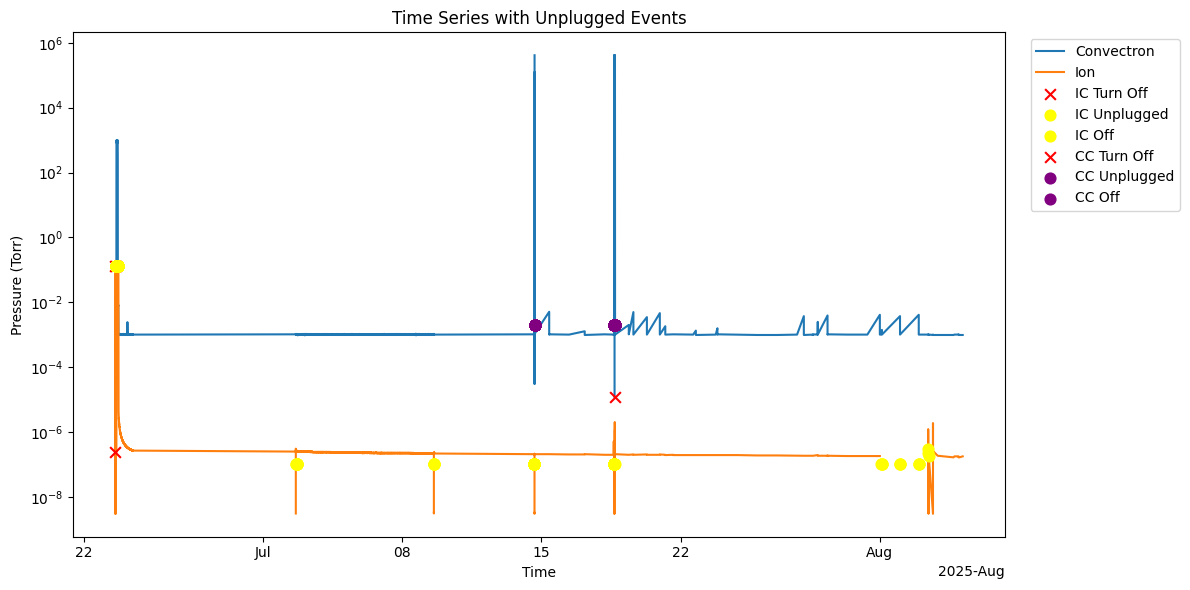

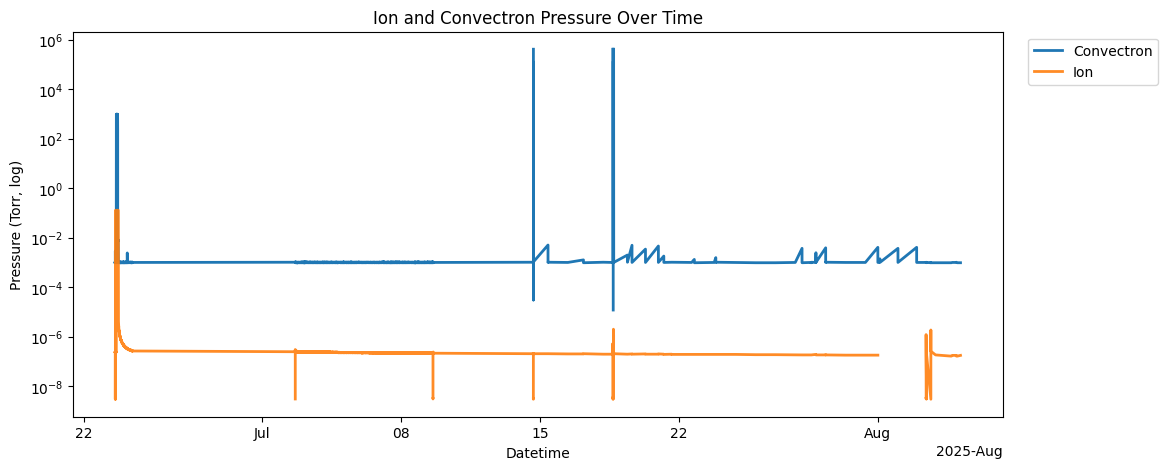

In [107]:
#  time vs ion and convectron pressure w event markers
plot_time_with_unplugged_events(df_altered, savepath=OUTPUT_PLOTS / "time_with_unplugged_events.png")
p_time_with_events = plot_time_with_events(
    df_altered,
    savepath=OUTPUT_PLOTS / "pressure_over_time.png"
)


In [105]:
out = DATA_PROCESSED / "processed_edaALL.csv"
df_altered.to_csv(out, index=False)
print(f"Saved combined data to {out}")

Saved combined data to ..\data\processed\processed_edaALL.csv
